# Defining the Aerobic Safety Margin

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
from itertools import product

import cmocean
import intake
import matplotlib.pyplot as plt
import metabolic as mi
import numpy as np
import thermodyn
import util
import xarray as xr

## Load World Ocean Atlas data

Access `intake` catalog for remote data.

In [ ]:
catalog = intake.open_catalog("data/catalogs/woa2018-catalog.yml")
catalog

### Generate merged dataset
Loop over variables of interest; generate a combined dataset.

In [4]:
ds_list = []

variables = dict(
    oxygen=dict(keep_vars=["o_an", "depth_bnds"]),
    temperature=dict(keep_vars=["t_an"]),
    salinity=dict(keep_vars=["s_an"]),
)
for variable, info in variables.items():
    ds_list.append(
        catalog[variable](time_code=0)
        .to_dask()[info["keep_vars"]]
        .isel(time=0, drop=True)
        .sel(depth=slice(0, 1000.0))
    )
ds = xr.merge(ds_list)

ds["pO2"] = thermodyn.compute_pO2(
    O2=ds.o_an,
    T=ds.t_an,
    S=ds.s_an,
    depth=xr.full_like(ds.t_an, fill_value=1.0) * ds.depth,
    gravimetric_units=True,
)

ds["dz"] = ds.depth_bnds.diff("nbounds").squeeze()
ds["area"] = util.compute_grid_area(ds)
ds["volume"] = (ds.dz * ds.area).where(ds.t_an.notnull())
ds.volume.attrs["long_name"] = "Volume"
ds.volume.attrs["units"] = "m^3"

ds.lat.attrs["long_name"] = "Latitude"
ds.lat.attrs["units"] = "°N"

ds = ds.compute()
ds

<xarray.Dataset>
Dimensions:     (depth: 47, lat: 180, lon: 360, nbounds: 2)
Coordinates:
  * lat         (lat) float32 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon         (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * depth       (depth) float32 0.0 5.0 10.0 15.0 ... 850.0 900.0 950.0 1e+03
Dimensions without coordinates: nbounds
Data variables:
    o_an        (depth, lat, lon) float32 nan nan nan nan ... 303.3 303.3 303.3
    depth_bnds  (depth, nbounds) float32 0.0 2.5 2.5 ... 975.0 975.0 1.025e+03
    t_an        (depth, lat, lon) float32 nan nan nan ... -0.1925 -0.1925
    s_an        (depth, lat, lon) float32 nan nan nan nan ... 34.91 34.91 34.91
    pO2         (depth, lat, lon) float32 nan nan nan nan ... 21.16 21.16 21.16
    dz          (depth) float32 2.5 5.0 5.0 5.0 5.0 ... 50.0 50.0 50.0 50.0 50.0
    area        (lat, lon) float64 1.079e+08 1.079e+08 ... 1.079e+08 1.079e+08
    volume      (depth, lat, lon) float64 nan nan nan ... 5.395e+09 5.395e+09
Attributes: (12/49)
    Conventions:                     CF-1.6, ACDD-1.3
    title:                           World Ocean Atlas 2018 : mole_concentrat...
    summary:                         Climatological mean dissolved oxygen for...
    references:                      Garcia, H. E., K. Weathers, C. R. Paver,...
    institution:                     National Centers for Environmental Infor...
    comment:                         global climatology as part of the World ...
    ...                              ...
    publisher_email:                 NCEI.info@noaa.gov
    nodc_template_version:           NODC_NetCDF_Grid_Template_v2.0
    license:                         These data are openly available to the p...
    metadata_link:                   https://www.nodc.noaa.gov/OC5/woa18/
    date_created:                    2019-07-29 
    date_modified:                   2019-07-29

### Peak and verify

Make a few plots to ensure that every is as expected.

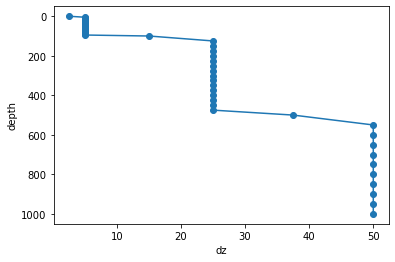

In [5]:
ds.dz.plot(y='depth', yincrease=False, marker='o');

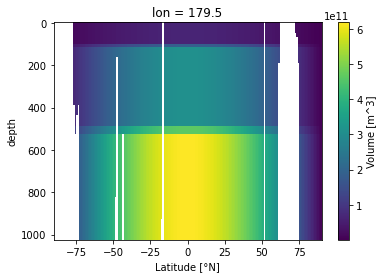

In [6]:
ds.volume.sel(lon=179.5).plot(yincrease=False);

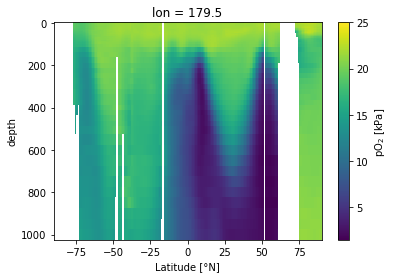

In [7]:
ds.pO2.sel(lon=179.5).plot(yincrease=False, vmax=25);

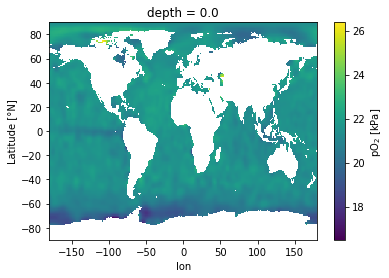

In [8]:
ds.pO2.sel(depth=0.0).plot();

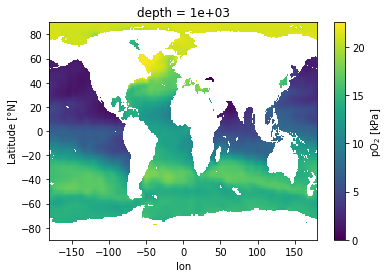

In [9]:
ds.pO2.sel(depth=1000.0).plot();

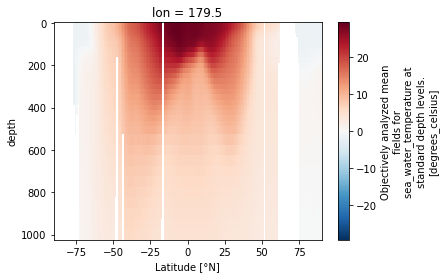

In [10]:
ds.t_an.sel(lon=179.5).plot(yincrease=False);

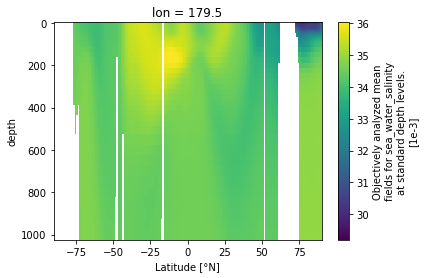

In [11]:
ds.s_an.sel(lon=179.5).plot(yincrease=False);

## Load trait space data

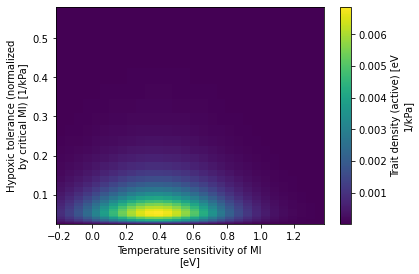

In [12]:
curator = util.curator_local_assets()
cat = curator.open_catalog()
ds_trait_space = cat['trait-space-hires'].to_dask().load()

ds_trait_space.trait_spc_active.plot();

## Define viable traits

Loop over trait space and store an index array into geographic space for each viable trait.

In [13]:
%%time

trait_kji_ndx = {}
for v in ['trait_spc_active', 'trait_spc_resting']:

    # get trait space vars
    trait_space = ds_trait_space[v]
    hypoxic_tol, temp_sens = trait_space.dims

    # loop over trait space and lat bands, sum trait frequency
    trait_kji_ndx[v] = {}
    for i, A_parm in enumerate(trait_space[hypoxic_tol].values):
        trait_kji_ndx[v][i] = {}
        for j, Eo in enumerate(trait_space[temp_sens].values):
            # compute metabolic index
            Phi = mi.Phi(ds.pO2, ds.t_an, A_parm, Eo, dEodT=mi.dEodT_bar)
            (I,) = np.asarray((1 < Phi) & (Phi <= 2)).ravel().nonzero()
            trait_kji_ndx[v][i][j] = I

CPU times: user 52.6 s, sys: 6.47 s, total: 59.1 s
Wall time: 1min


## Volume of viable habitat in trait-space

In [14]:
%%time
dso_vol = xr.Dataset()
viable_trait_mask = np.zeros(ds.pO2.shape)

for v in ['trait_spc_active', 'trait_spc_resting']:
    trait_space = ds_trait_space[v]
    metabolic_baseline = trait_space.attrs['metabolic_baseline']
    hypoxic_tol, temp_sens = trait_space.dims

    vol = xr.full_like(trait_space, fill_value=0.0)

    for i, A_parm in enumerate(trait_space[hypoxic_tol].values):
        for j, Eo in enumerate(trait_space[temp_sens].values):

            K, J, I = np.unravel_index(trait_kji_ndx[v][i][j], ds.pO2.shape)
            viable_trait_mask[:] = 0.0
            viable_trait_mask[K, J, I] = 1.0
            # Phi = mi.Phi(ds.pO2, ds.t_an, Ac=A_parm, Eo=Eo, dEodT=mi.dEodT_bar)
            # viable_trait_mask = xr.where((1 < Phi) & (Phi <= 2), 1.0, 0.0)

            vol[i, j] += (ds.volume * viable_trait_mask).sum(['depth', 'lat', 'lon'])

    vol_percent = 100.0 * vol / ds.volume.sum()
    vol_percent.attrs['long_name'] = 'Ocean volume'
    vol_percent.attrs['units'] = '%'

    vol *= 1e-6  # convert to 10^6 m^3
    vol.attrs['units'] = '10$^6$ m$^3$'

    name = f'vol_habitat_{metabolic_baseline}'
    dso_vol[name] = vol
    dso_vol[f'{name}_percent'] = vol_percent

dso_vol

CPU times: user 50.2 s, sys: 2.64 s, total: 52.9 s
Wall time: 53.8 s


<xarray.Dataset>
Dimensions:                      (Ac: 30, Eo: 30, Ao: 30)
Coordinates:
  * Ac                           (Ac) float64 0.0258 0.0287 ... 0.4973 0.5528
  * Eo                           (Eo) float64 -0.191 -0.1379 ... 1.295 1.348
  * Ao                           (Ao) float64 0.0613 0.0684 ... 1.282 1.429
Data variables:
    vol_habitat_active           (Ac, Eo) float64 0.0 0.0 ... 1.361e+10
    vol_habitat_active_percent   (Ac, Eo) float64 0.0 0.0 0.0 ... 4.178 4.049
    vol_habitat_resting          (Ao, Eo) float64 5.862e+10 ... 5.153e+09
    vol_habitat_resting_percent  (Ao, Eo) float64 17.43 17.46 ... 1.278 1.532

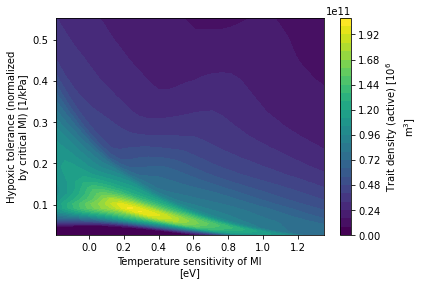

In [15]:
dso_vol.vol_habitat_active.plot.contourf(levels=30);

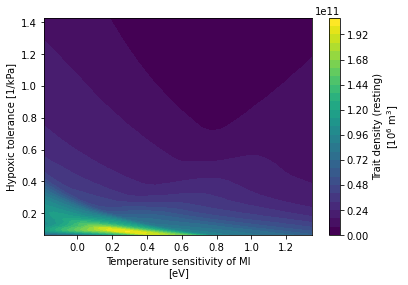

In [16]:
dso_vol.vol_habitat_resting.plot.contourf(levels=30);

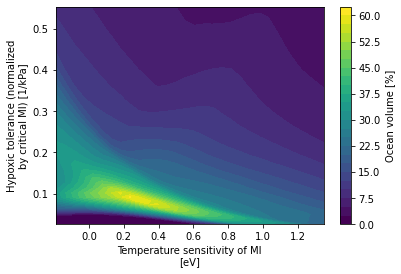

In [17]:
dso_vol.vol_habitat_active_percent.plot.contourf(levels=30);

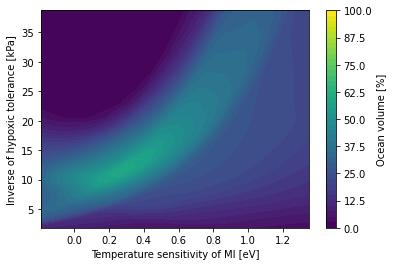

In [18]:
plt.contourf(
    dso_vol.vol_habitat_active_percent.Eo,
    1 / dso_vol.vol_habitat_active_percent.Ac,
    dso_vol.vol_habitat_active_percent,
    levels=np.arange(0, 102.5, 2.5),
)
cb = plt.colorbar()
plt.xlabel(util.attrs_label(dso_vol.Eo.attrs))

inv_attrs = dict(**dso_vol.Ac.attrs)
inv_attrs['long_name'] = 'Inverse of hypoxic tolerance'
inv_attrs['units'] = 'kPa'
plt.ylabel(util.attrs_label(inv_attrs))
cb.ax.set_ylabel(util.attrs_label(vol_percent.attrs));

## Examine trait frequency as a function of latitude

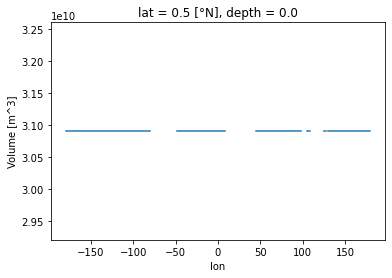

In [26]:
ds.volume.sel(lat=0.5).isel(depth=slice(0, 1)).plot()

In [32]:
%%time
# construct an ATmax distribution with pre-defined bins
ATmax_bin_edge = np.arange(10, 64, 2)
ATmax_bin_c = np.vstack((ATmax_bin_edge[:-1], ATmax_bin_edge[1:])).mean(axis=0)
ATmax_bins = xr.DataArray(
    ATmax_bin_c,
    dims=('ATmax'),
    coords={'ATmax': ATmax_bin_c},
)
lat_var = xr.full_like(ds.pO2.isel(lon=0, depth=0, drop=True), fill_value=0.0)
trait_wgt = xr.full_like(ds.pO2, fill_value=0.0)

dsets = {}
for v in ['trait_spc_resting', 'trait_spc_active']:

    # get trait space vars
    trait_space = ds_trait_space[v]
    metabolic_baseline = trait_space.attrs['metabolic_baseline']
    assert metabolic_baseline in ['active', 'resting']

    ATmax = ds_trait_space[f'ATmax_{metabolic_baseline}']
    hypoxic_tol, temp_sens = trait_space.dims

    # initialize trait distributions
    dso = xr.Dataset()
    dso['ATmax_dist'] = ATmax_bins * lat_var
    dso[f'{hypoxic_tol}_dist'] = trait_space[hypoxic_tol] * lat_var
    dso[f'{temp_sens}_dist'] = trait_space[temp_sens] * lat_var

    # loop over trait space and lat bands, sum trait frequency
    for i, A_parm in enumerate(trait_space[hypoxic_tol].values):
        for j, Eo in enumerate(trait_space[temp_sens].values):

            if np.isnan(ATmax[i, j]):
                continue

            # compute metabolic index
            # Phi = mi.Phi(ds.pO2, ds.t_an, A_parm, Eo, dEodT=mi.dEodT_bar)
            # if metabolic_baseline == 'active':
            #     trait_wgt = xr.where((1 < Phi) & (Phi <= 2), trait_space[i, j], 0.0)
            # else:
            #     trait_wgt = xr.where(Phi > 1, trait_space[i, j], 0.0)

            K, J, I = np.unravel_index(trait_kji_ndx[v][i][j], ds.pO2.shape)

            # loop over latitude and accumulate the frequency
            ndx_bin = np.searchsorted(ATmax_bin_edge, ATmax[i, j], side='left')

            for kk, jj, ii in zip(K, J, I):
                freq_j = trait_space[i, j]  # * ds.volume[kk, jj, ii]
                dso['ATmax_dist'][ndx_bin, jj] += freq_j
                dso[f'{hypoxic_tol}_dist'][i, jj] += freq_j
                dso[f'{temp_sens}_dist'][j, jj] += freq_j

            continue
            trait_wgt.data[:] = 0.0
            trait_wgt.data[K, J, I] = trait_space[i, j]

            for j_lat in range(ds.sizes['lat']):
                freq_j = (trait_wgt.isel(lat=j_lat) * ds.volume.isel(lat=j_lat)).sum()

                dso['ATmax_dist'][ndx_bin, j_lat] += freq_j
                dso[f'{hypoxic_tol}_dist'][i, j_lat] += freq_j
                dso[f'{temp_sens}_dist'][j, j_lat] += freq_j

    # normalize so integral is 1.0
    for key in dso.data_vars:
        dso[key] /= dso[key].sum()

    dsets[v] = dso

dsets

KeyboardInterrupt: 

### Results

Make plots of trait distributions as a function of latitude

In [30]:
def percentile(dso, var, coord, q):
    nj = dso.sizes['lat']
    cdf = dso[var].cumsum(dim=coord) / dso[var].sum(coord)
    p = np.ones((len(q), nj)) * np.nan
    for i in range(len(q)):
        for j in range(nj):
            p[i, j] = np.interp(q[i], cdf[:, j], dso[coord])
    return p

KeyError: 'trait_spc_resting'

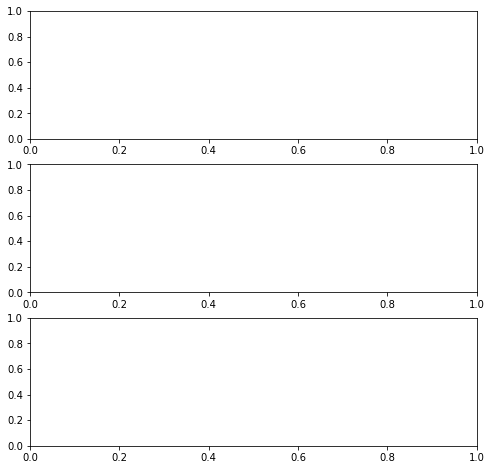

In [31]:
fig, axs = plt.subplots(3, 1, figsize=(8, 8), squeeze=False)

dso = dsets['trait_spc_resting']

for j, v in enumerate(['ATmax_dist', 'Ao_dist', 'Eo_dist']):
    ax = axs[j, 0]
    coord = dso[v].dims[0]
    ax.pcolormesh(dso[v].lat, dso[v][coord], dso[v], cmap=cmocean.cm.dense)

    # construct cumulative prob density function
    p = percentile(dso, v, coord, [0.25, 0.5, 0.75])
    ax.plot(dso[v].lat, p[1, :], '-', color='tab:red')
    ax.plot(dso[v].lat, p[0, :], '--', color='tab:red')
    ax.plot(dso[v].lat, p[2, :], '--', color='tab:red')

    if j == 2:
        ax.set_xlabel(util.attrs_label(dso.lat))
    ax.set_ylabel(util.attrs_label(dso[v]))
    ax.set_title(v)

plt.suptitle('Resting metabolism', fontweight='bold')
plt.tight_layout();

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(8, 8), squeeze=False)

dso = dsets['trait_spc_resting']

for j, v in enumerate(['ATmax_dist', 'Ao_dist', 'Eo_dist']):
    ax = axs[j, 0]
    coord = dso[v].dims[0]
    ax.pcolormesh(dso[v].lat, dso[v][coord], dso[v], cmap=cmocean.cm.dense)

    # construct cumulative prob density function
    p = percentile(dso, v, coord, [0.25, 0.5, 0.75])
    ax.plot(dso[v].lat, p[1, :], '-', color='tab:red')
    ax.plot(dso[v].lat, p[0, :], '--', color='tab:red')
    ax.plot(dso[v].lat, p[2, :], '--', color='tab:red')

    if j == 2:
        ax.set_xlabel(util.attrs_label(dso.lat))
    ax.set_ylabel(util.attrs_label(dso[v]))
    ax.set_title(v)

plt.suptitle('Active metabolism', fontweight='bold')
plt.tight_layout();

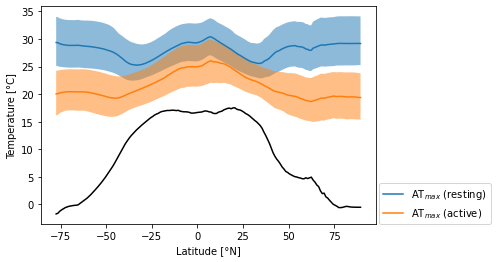

In [22]:
dso = dsets['trait_spc_resting']
ATmax_p_rest = percentile(dso, 'ATmax_dist', 'ATmax', [0.25, 0.5, 0.75])

dso = dsets['trait_spc_active']
ATmax_p_active = percentile(dso, 'ATmax_dist', 'ATmax', [0.25, 0.5, 0.75])
lat = dso.lat

fig, ax = plt.subplots()

ax.plot(lat, ATmax_p_rest[1, :], '-', label='AT$_{max}$ (resting)')
ax.fill_between(lat, ATmax_p_rest[0, :], ATmax_p_rest[2, :], zorder=-100, alpha=0.5)

ax.plot(lat, ATmax_p_active[1, :], '-', label='AT$_{max}$ (active)')
ax.fill_between(lat, ATmax_p_active[0, :], ATmax_p_active[2, :], zorder=-100, alpha=0.5)

ax.plot(ds.lat, ds.t_an.mean(['lon', 'depth']), '-', color='k')

ax.set_ylabel('Temperature [°C]')
ax.set_xlabel(util.attrs_label(dso.lat))

ax.legend(loc=(1.01, 0));